In [61]:
%autoreload 2
%reload_ext autoreload
import colabexts
from colabexts.jcommon import *

jpath=os.path.dirname(colabexts.__file__)
jcom = f'{jpath}/jcommon.ipynb'
%run $jcom

import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False
print(tf.__version__)


2.5.0


In [62]:
if ("dfn1" not in globals()):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn

In [63]:
dfn

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,1307.75
2009-01-01 00:20:00,-8.41,996.57,1309.80
2009-01-01 00:30:00,-8.51,996.53,1310.24
...,...,...,...
2016-12-31 23:40:00,-3.16,999.82,1288.39
2016-12-31 23:50:00,-4.23,999.81,1293.56
2017-01-01 00:00:00,-4.82,999.82,1296.38


Date Time
2009-01-01 00:10:00   -8.02
2009-01-01 00:20:00   -8.41
2009-01-01 00:30:00   -8.51
                       ... 
2016-12-31 23:40:00   -3.16
2016-12-31 23:50:00   -4.23
2017-01-01 00:00:00   -4.82
Name: T (degC), Length: 420551, dtype: float64

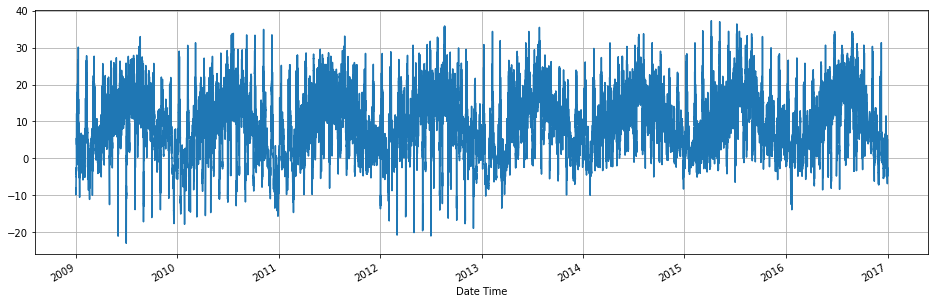

In [110]:
#In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and 
#there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

tf.random.set_seed(13)      #Setting seed to ensure reproducibility.

# Univariant - single step prediction
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.plot(subplots=True)
uni_data

Date Time
2009-01-01 00:10:00          NaN
2009-01-01 00:20:00          NaN
2009-01-01 00:30:00          NaN
                         ...    
2016-12-31 23:40:00    12.610147
2016-12-31 23:50:00    12.609334
2017-01-01 00:00:00    12.608521
Name: T (degC), Length: 420551, dtype: float64

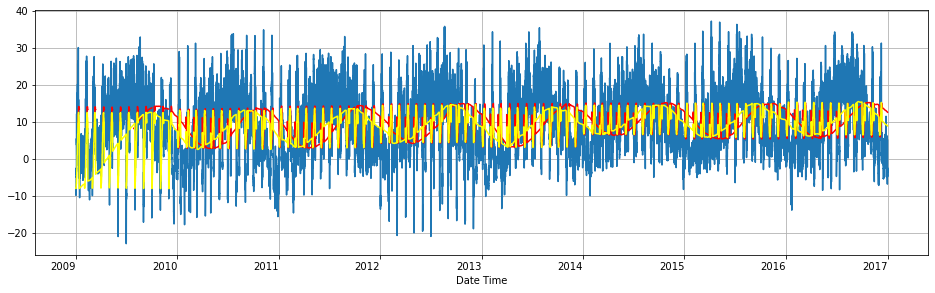

In [127]:
u3 = uni_data.rolling(window=30000).mean()
uni_data.plot(subplots=True)
u3.plot(subplots=True, color='red')

ema = uni_data.ewm(span=30000,adjust=False).mean()
ema.plot(subplots=True, color='yellow')

u3


In [65]:
#It is important to scale features before training a neural network. Standardization is a 
#common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.
#You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

#***NOTE*** Note: The mean and standard deviation should only be computed using the training data.
#
uni_data = uni_data.values

TRAIN_SPLIT    = 300000
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std  = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
len(uni_data), uni_data

(420551,
 array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
        -1.55883897, -1.62715193]))

In [66]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        #print(f"++ {i}  {start_index} {end_index} \r", end="")
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        dt = np.reshape(dataset[indices], (history_size, -1))
        data.append(dt)
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

#Let's now create the data for the univariate model. For part 1, the model will be given the 
#last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

univariate_past_history = 20
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,  univariate_past_history, univariate_future_target)

print ('Single window of past history:', x_train_uni[0][0:3], "...", x_train_uni[0][-3:])
print ('\n Target temperature to predict', y_train_uni[0], y_train_uni[1])

Single window of past history: [[-1.99766294]
 [-2.04281897]
 [-2.05439744]] ... [[-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict -2.0949220845536356 -2.1099740943453704


In [67]:
for i in range(25):
    print(i, uni_data[i], end=";")

0 -1.9976629443608853;1 -2.0428189737360904;2 -2.054397442806656;3 -2.0312405046655253;4 -2.026609117037299;5 -2.001136485082055;6 -1.9513490680786236;7 -1.9513490680786236;8 -1.9849266283832634;9 -2.045134667550204;10 -2.08334361548307;11 -2.0972377783677487;12 -2.0937642376465786;13 -2.0914485438324655;14 -2.0717651464125044;15 -2.0717651464125044;16 -2.07639653404073;17 -2.089132850018353;18 -2.092606390739522;19 -2.1041848598100876;20 -2.1041848598100876;21 -2.0949220845536356;22 -2.1099740943453704;23 -2.1169211757877098;24 -2.1377624201147274;

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [68]:
def create_time_steps(length):
    return list(range(-length, 0))

<module 'matplotlib.pyplot' from '/Users/snarayan/anaconda3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

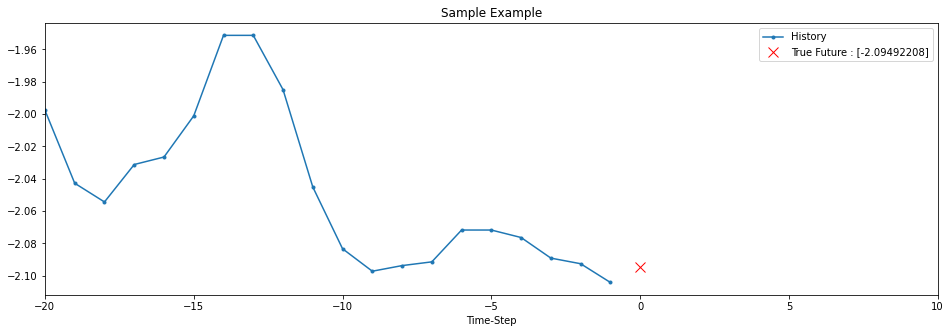

In [69]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            y = plot_data[i].flatten()
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i]+ " : " + str(y))
        else:
            y = plot_data[i].flatten()
            plt.plot(time_steps, y, marker[i], label=labels[i] )

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [70]:
def baseline(history):
    return np.mean(history)

baseline(x_train_uni)

4.135588689781763e-05

<module 'matplotlib.pyplot' from '/Users/snarayan/anaconda3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

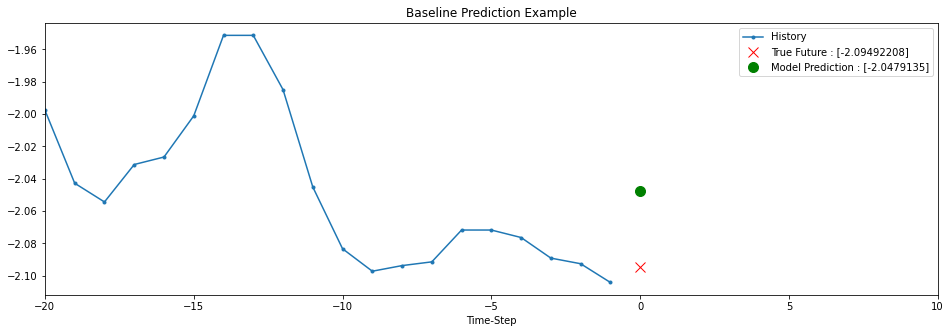

In [71]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [72]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(x_train_uni.shape)

(299980, 20, 1)


You will see the LSTM requires the input shape of the data it is being given.

In [73]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [74]:
for x, y in val_univariate.take(1):
    p = simple_lstm_model.predict(x)
    print( x.shape, p.shape)

(256, 20, 1) (256, 1)


In [75]:
#x_train_uni.shape, x_val_uni.shape, x_train_uni,x_val_uni

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [76]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)



Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.4120 - val_loss: 0.1440
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1217 - val_loss: 0.0439
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0604 - val_loss: 0.0373
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0551 - val_loss: 0.0338
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0395 - val_loss: 0.0320
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0429 - val_loss: 0.0310
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0394 - val_loss: 0.0296
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0372 - val_loss: 0.0287
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0373 - val_loss: 0.0277
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0339 - val_loss: 0.0266

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

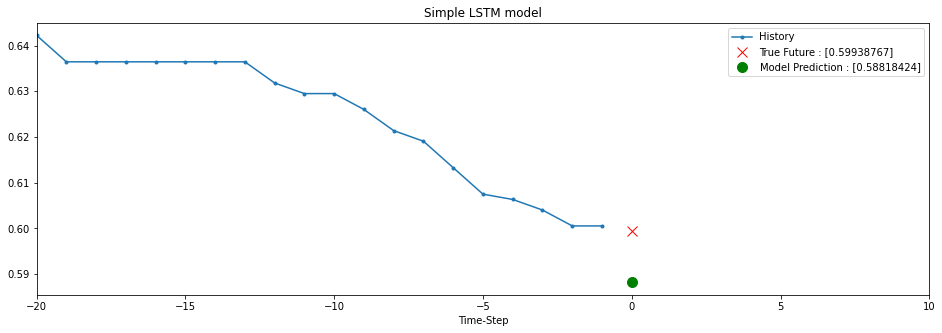

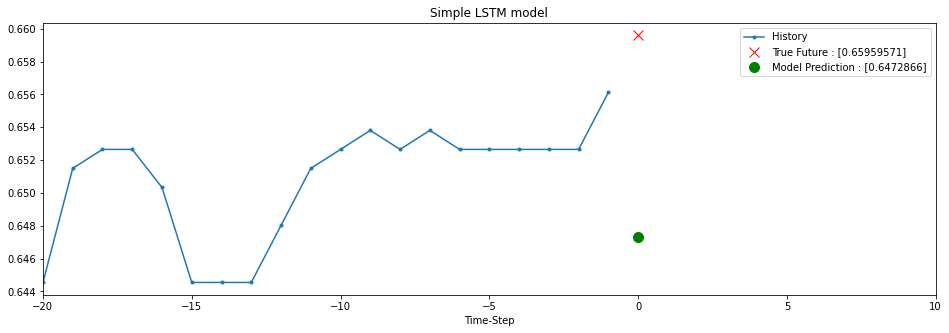

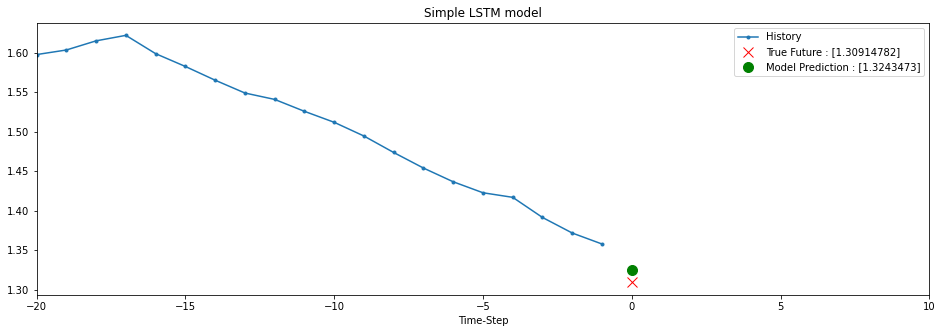

In [77]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

In [78]:
simple_lstm_model.save("simple_lstm_model.hd5")

INFO:tensorflow:Assets written to: simple_lstm_model.hd5/assets


INFO:tensorflow:Assets written to: simple_lstm_model.hd5/assets


## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [79]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [80]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,996.52,-8.02,1307.75
2009-01-01 00:20:00,996.57,-8.41,1309.80
2009-01-01 00:30:00,996.53,-8.51,1310.24
2009-01-01 00:40:00,996.51,-8.31,1309.19
2009-01-01 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f820fede970>,
      dtype=object)

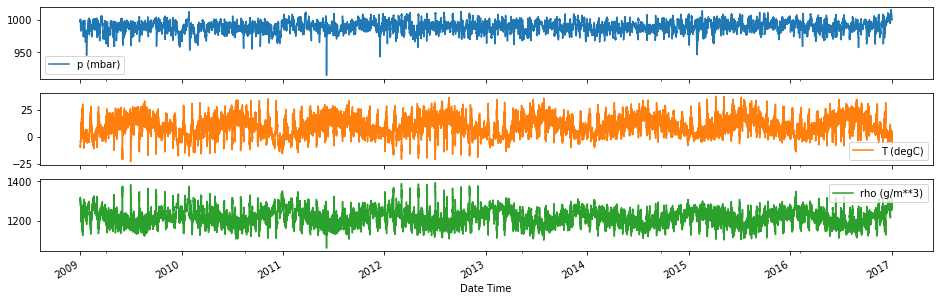

In [81]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [82]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_mean, data_std

(array([ 988.65117607,    9.2332563 , 1216.40583777]),
 array([ 8.23552219,  8.6367204 , 40.86842488]))

In [83]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [84]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [85]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [86]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

Single window of past history : (120, 3)


((299280, 120, 3), (299280,), (119759, 120, 3), (119759,))

In [87]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [88]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [89]:
x_train_single.shape[-2:]

(120, 3)

In [90]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [91]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 9s 42ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2624 - val_loss: 0.2433
Epoch 3/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2613 - val_loss: 0.2441
Epoch 4/10
200/200 [==============================] - 8s 41ms/step - loss: 0.2569 - val_loss: 0.2470
Epoch 5/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2265 - val_loss: 0.2355
Epoch 6/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2418 - val_loss: 0.2626
Epoch 7/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2414 - val_loss: 0.2516
Epoch 8/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2402 - val_loss: 0.2394
Epoch 9/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2444 - val_loss: 0.2462
Epoch 10/10
200/200 [==============================] - 8s 40ms/step - loss: 0.2381 - val_lo

In [92]:
single_step_model.save("single_step_model.hd5")

INFO:tensorflow:Assets written to: single_step_model.hd5/assets


INFO:tensorflow:Assets written to: single_step_model.hd5/assets


In [93]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

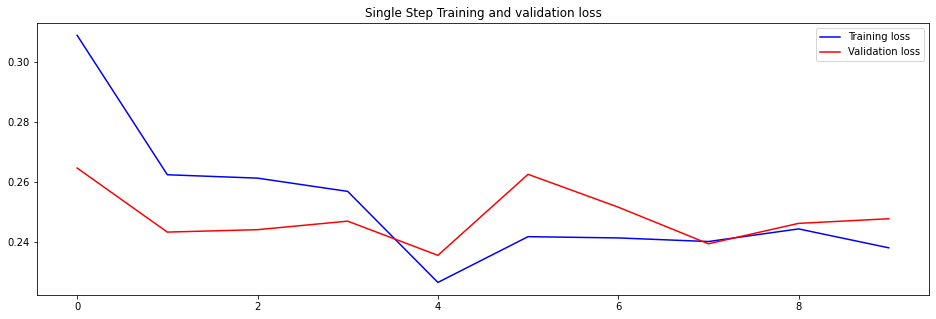

In [94]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

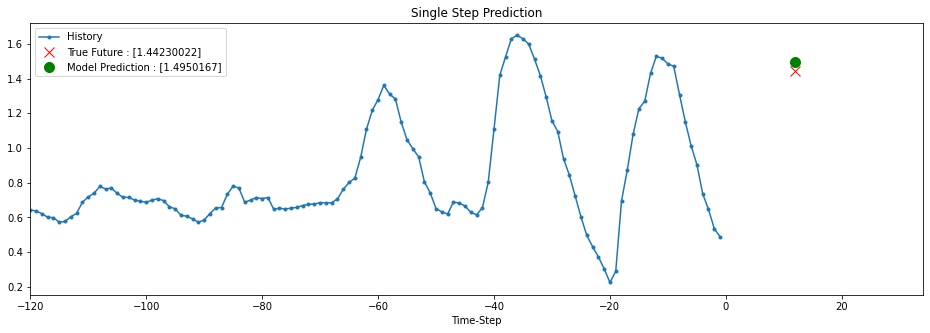

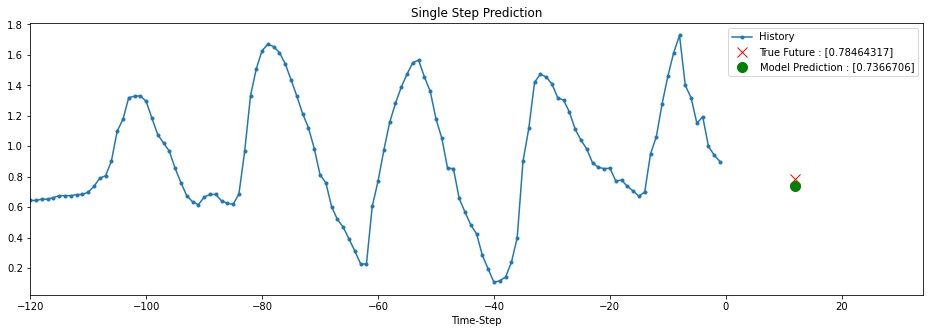

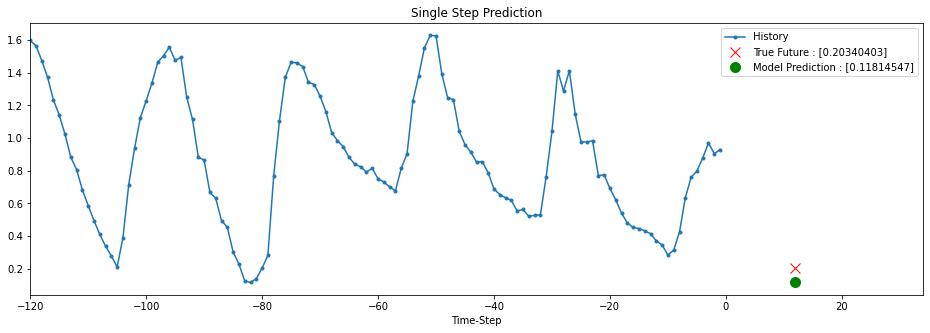

In [95]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

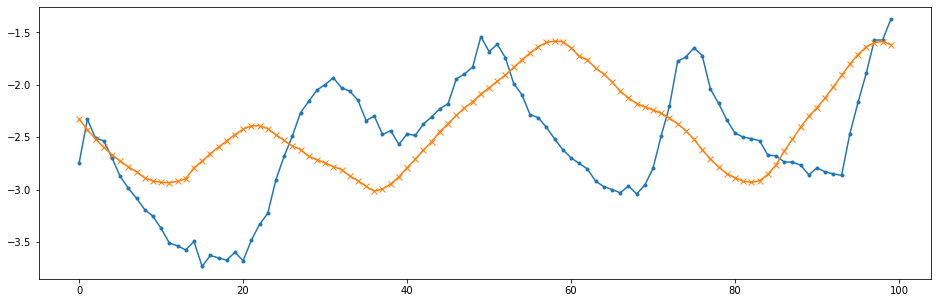

In [96]:
st,end, history,target = 0, 100, 720,72
xo,yo=x_train_single, y_train_single
xo.shape
yoo=yo[st:st+end*6:6]
#plt.plot(yo[0:100], marker='.')
pp=[]
for xxo in xo[st:st+end*6:6]:
    p=single_step_model.predict(np.expand_dims(xxo, axis=0))[0]
    pp.append(p)
    
plt.plot(yoo, marker='.')
plt.plot(pp, marker='x')

In [97]:
yo

array([-2.74331635, -2.69931817, -2.63911013, ...,  0.7753804 ,
        0.78001179,  0.78464317])

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [98]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [99]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [100]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [101]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

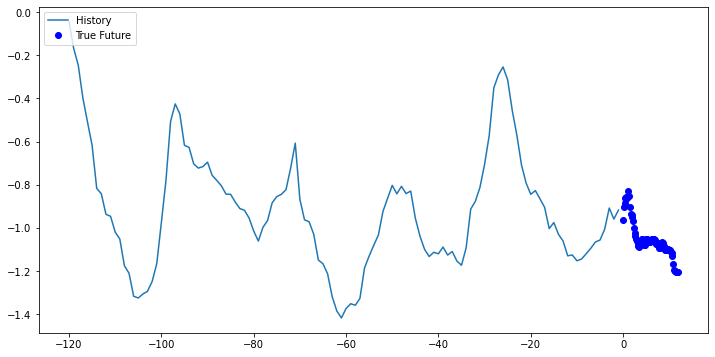

In [102]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [103]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [104]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [105]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 16s 71ms/step - loss: 0.4952 - val_loss: 0.3032
Epoch 2/10
200/200 [==============================] - 14s 69ms/step - loss: 0.3468 - val_loss: 0.2847
Epoch 3/10
200/200 [==============================] - 1667s 8s/step - loss: 0.3220 - val_loss: 0.2368
Epoch 4/10
200/200 [==============================] - 14s 69ms/step - loss: 0.2355 - val_loss: 0.1998
Epoch 5/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1940 - val_loss: 0.1946
Epoch 6/10
200/200 [==============================] - 14s 69ms/step - loss: 0.2031 - val_loss: 0.2082
Epoch 7/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1956 - val_loss: 0.2048
Epoch 8/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1938 - val_loss: 0.1945
Epoch 9/10
200/200 [==============================] - 14s 70ms/step - loss: 0.1967 - val_loss: 0.1880
Epoch 10/10
200/200 [==============================] - 14s 69ms/step - loss: 0.189

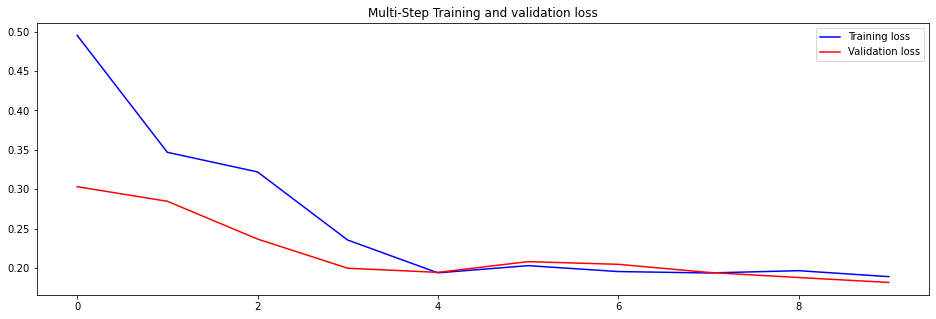

In [106]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

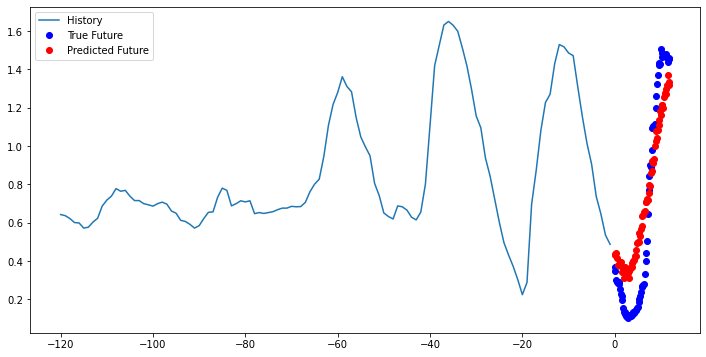

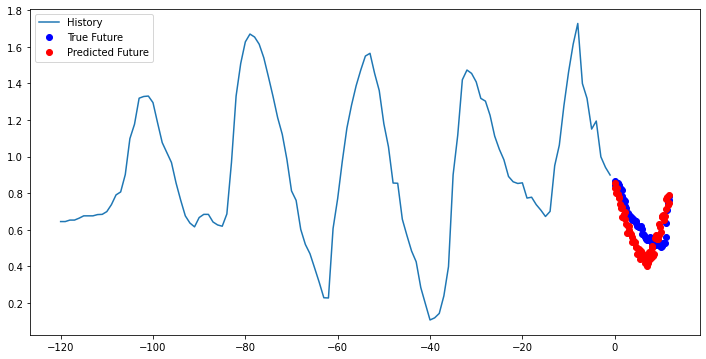

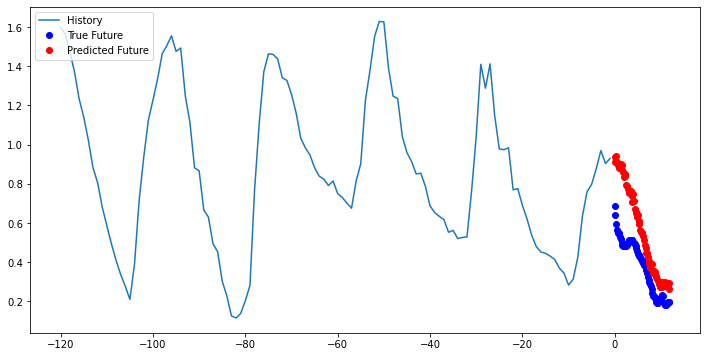

In [107]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])